In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
sys.path.append("..")
from train_and_inference.predict_and_visualize import *
from data import utils
from data import load_raw_data

In [54]:
# pcd = load_raw_data.load_pcd_plyfile_new_approach("/space/ariyanzarei/sorghum_segmentation/dataset/synthetic/2022-11-06/PointCloud/S11_29403.ply", True)
# points = pcd['points']
# labels = pcd['labels'].squeeze()

points, leaf_index, semantic_index  = load_raw_data.load_real_ply_with_labels("/space/ariyanzarei/sorghum_segmentation/dataset/real_data/labeled/ply_files/BTx_623_3001_330755982981.ply")
points = points[semantic_index==1]
labels = leaf_index[semantic_index==1]


points = torch.from_numpy(points).type(torch.DoubleTensor).unsqueeze(0).cuda()

instance_model = load_model("SorghumPartNetInstance", -1).double()

pred_instance = instance_model(points)

distance_pred = torch.cdist(pred_instance, pred_instance)
distance_pred = distance_pred.cpu().detach().numpy().T
distance_pred = np.squeeze(distance_pred)

pred_instance = pred_instance.cpu().detach().numpy().squeeze()
clustering = DBSCAN(eps=1, min_samples=10).fit(pred_instance)
pred_final_cluster = clustering.labels_

colors = np.zeros((labels.shape[0],3))
d_colors = utils.distinct_colors(len(list(set(labels))))

for i, l in enumerate(list(set(labels))):
    colors[labels == l, :] = d_colors[i]

Using Version  6  and  epoch=8-step=48599.ckpt


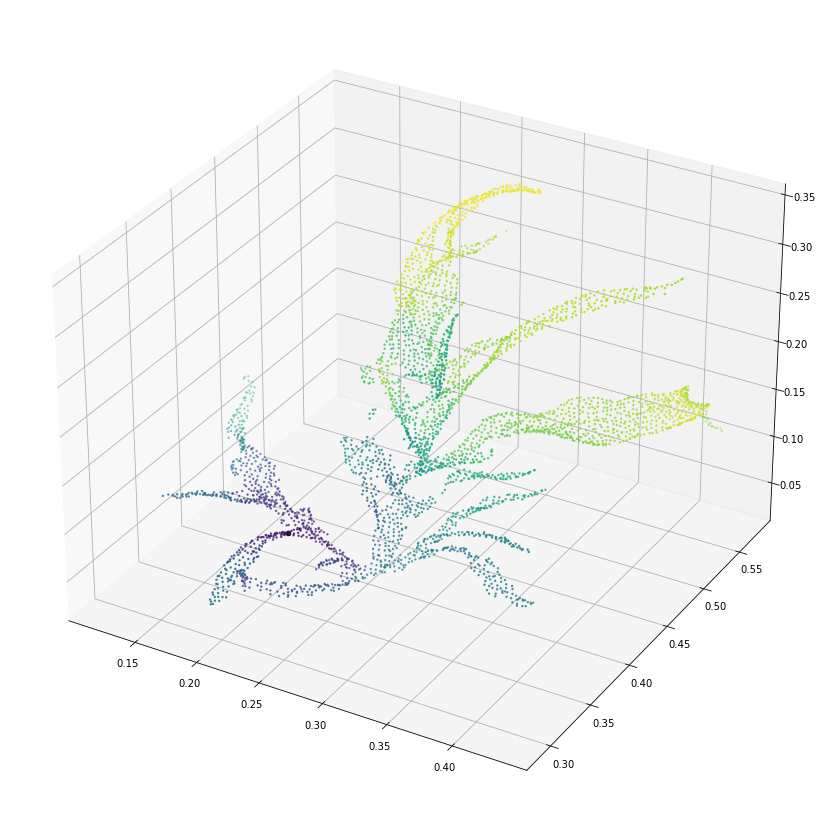

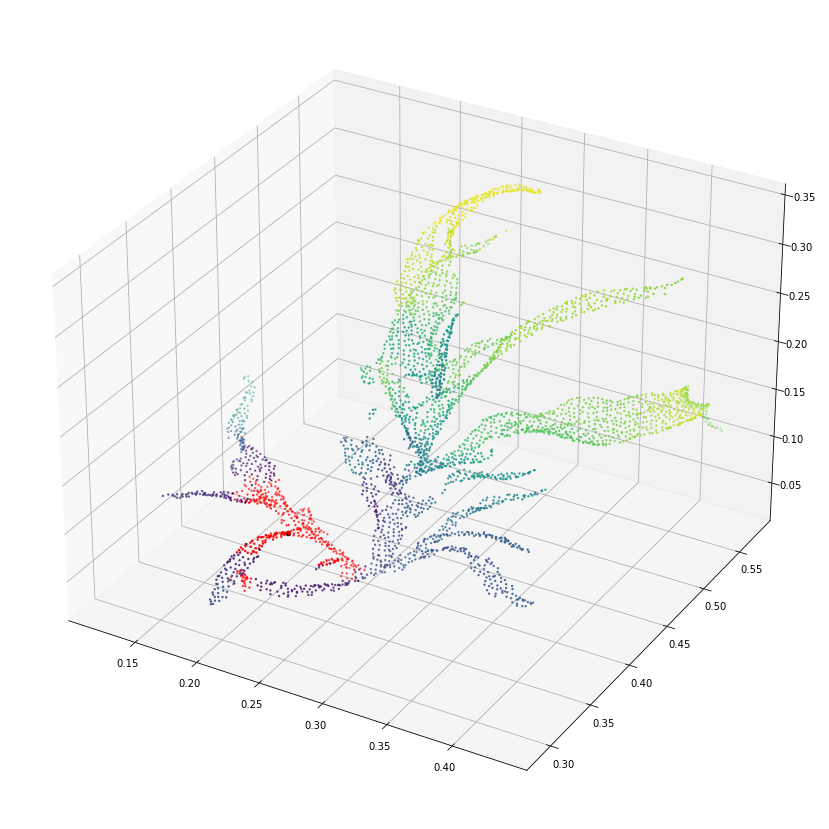

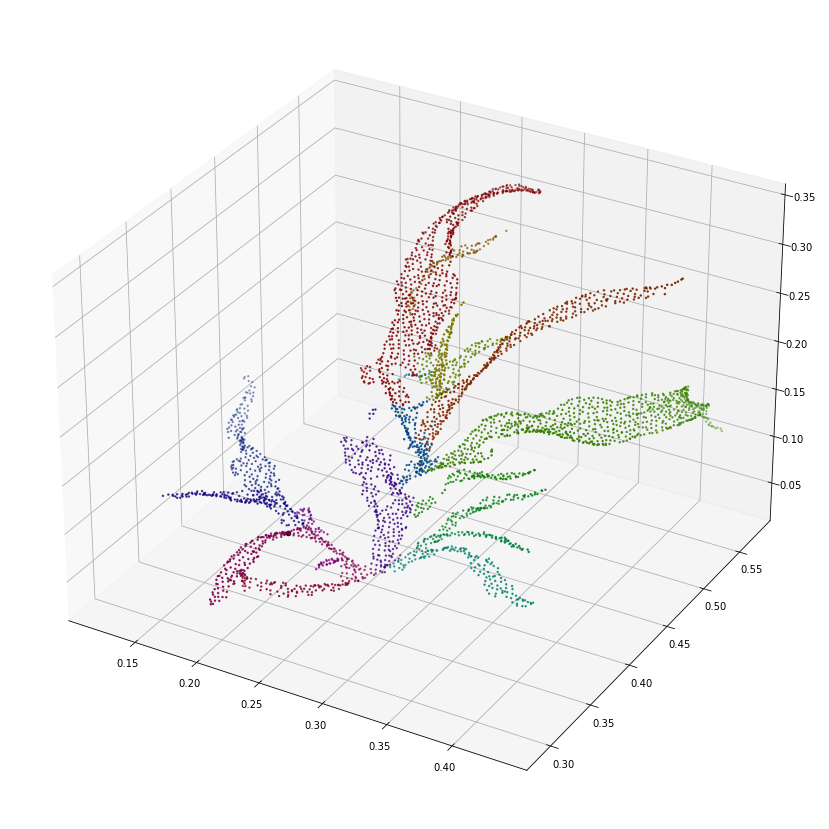

In [58]:
offline_points = points.squeeze().cpu().detach()
thresholded_distance_pred = distance_pred.copy()
thresholded_distance_pred[thresholded_distance_pred<5] = 0

selected_point = 200

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(offline_points[selected_point,0],offline_points[selected_point,1],offline_points[selected_point,2], s=20, c='black')
ax.scatter(offline_points[:,0],offline_points[:,1],offline_points[:,2], s=2, c=distance_pred[selected_point])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(offline_points[selected_point,0],offline_points[selected_point,1],offline_points[selected_point,2], s=20, c='black')
ax.scatter(offline_points[thresholded_distance_pred[selected_point]>0,0],offline_points[thresholded_distance_pred[selected_point]>0,1],offline_points[thresholded_distance_pred[selected_point]>0,2], s=2, c=thresholded_distance_pred[selected_point,thresholded_distance_pred[selected_point]>0])
ax.scatter(offline_points[thresholded_distance_pred[selected_point]==0,0],offline_points[thresholded_distance_pred[selected_point]==0,1],offline_points[thresholded_distance_pred[selected_point]==0,2], s=2, c='red')
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')
ax.scatter(offline_points[selected_point,0],offline_points[selected_point,1],offline_points[selected_point,2], s=20, c='black')
ax.scatter(offline_points[:,0],offline_points[:,1],offline_points[:,2], s=2, c=colors)
plt.show()